# Tutorial

ldcpy is a utility for gathering and plotting derived quantities from NetCDF or Zarr files
using the Pangeo stack. This tutorial notebook targets comparing CESM data in
its original form to CESM data that has undergone lossy compression (meaning
that the reconstructed file is not exactly equivalent to the original file). The
tools provided in ldcpy are intended to highlight differences due to compression
artifacts in order to assist scientist in evaluating the amount of lossy
compression to apply to their data.

The CESM data used here are NetCDF files in "timeseries" file format, meaning
that each NetCDF file contains one (major) output variable (e.g., surface
temperature or precipitation rate) and spans multiple timesteps (daily, monthly,
6-hourly, etc.). CESM timeseries files are regularly released in large public
datasets.


In [1]:
# Add ldcpy root to system path
import sys

import astropy

sys.path.insert(0, '../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2

# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")

import ldcpy

# display the plots in this notebook
%matplotlib inline

## Overview


This notebook demonstrates the use of ldcpy on the sample data included with
this package. It explains how to open datasets (and view metadata), display
basic statistics about the data, and create both time-series and spatial plots
of the datasets and related quantitiess. Plot examples start out with the essential
arguments, and subsequent examples explore the additional plotting options that
are available.

For information about installation, see
[these instructions](https://ldcpy.readthedocs.io/en/latest/installation.html),
and for information about usage, see the API reference
[here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).


## Loading Datasets and Viewing Metadata


The first step in comparing the data is to load the data from the files that we
are interested into a "collection" for ldcpy to use. To do this, we use
ldcpy.open_datasets(). This function requires the following three arguments:

- _varnames_ : the variable(s) of interest to combine across files (typically
  the timeseries file variable name)
- _list_of_files_ : a list of full file paths (either relative or absolute)
- _labels_ : a corresponding list of names (or labels) for each file in the
  collection

Note: This function is a wrapper for xarray.open_mfdatasets(), and any
additional key/value pairs passed in as a dictionary are used as arguments to
xarray.open_mfdatasets(). For example, specifying the chunk size ("chunks") will
be important for large data (see LargeDataGladeNotebook.ipynb for more
information and an example).

We setup three different collections of timeseries datasets in these examples:

- _col_ts_ contains daily surface temperature (TS) data (2D data) for 100 days
- _col_prect_ contains daily precipitation rate (PRECT) data (2D data) for 60 days
- _col_t_ contains monthly temperature (T) data (3D data) for 3 months

These datasets are collections of variable data from several different netCDF
files, which are given labels in the third parameter to the
ldcpy.open_datasets() function. These names/labels can be whatever you want
(e.g., "orig", "control", "bob", ...), but they should be informative because
the names will be used to select the appropriate dataset later and as part of
the plot titles.

In this example, in each dataset collection we include a file with the original
(uncompressed) data as well as additional file(s) with the same data subject to
different levels of lossy compression.

_Note: If you do not need to get the data from files (e.g., you have already
used xarray.open_dataset()), then use ldcpy.collect_datasets() instead of
ldcpy.open_datasets (see example in AWSDataNotebook.ipynb)._


In [2]:
# col_ts is a collection containing TS data
col_ts = ldcpy.open_datasets(
    "cam-fv",
    ["TS"],
    [
        "../../../data/cam-fv/orig.TS.100days.nc",
        "../../../data/cam-fv/zfp1.0.TS.100days.nc",
        "../../../data/cam-fv/zfp1e-1.TS.100days.nc",
    ],
    ["orig", "zfpA1.0", "zfpA1e-1"],
)
# col_prect contains PRECT data
col_prect = ldcpy.open_datasets(
    "cam-fv",
    ["PRECT"],
    [
        "../../../data/cam-fv/orig.PRECT.60days.nc",
        "../../../data/cam-fv/zfp1e-7.PRECT.60days.nc",
        "../../../data/cam-fv/zfp1e-11.PRECT.60days.nc",
    ],
    ["orig", "zfpA1e-7", "zfpA1e-11"],
)
# col_t contains 3D T data (here we specify the chunk to be a single timeslice)
col_t = ldcpy.open_datasets(
    "cam-fv",
    ["T"],
    [
        "../../../data/cam-fv/cam-fv.T.3months.nc",
        "../../../data/cam-fv/c.fpzip.cam-fv.T.3months.nc",
    ],
    ["orig", "comp"],
    chunks={"time": 1},
)

dataset size in GB 0.07

dataset size in GB 0.04

dataset size in GB 0.04



---

Note that running the open_datasets function (as above) prints out the size of
each dataset collection. For *col_prect* , the chunks parameter is used by DASK
(which is further explained in LargeDataGladeNotebook.ipynb).

Printing a dataset collection reveals the dimension names, sizes, datatypes and
values, among other metadata. The dimensions and the length of each dimension
are listed at the top of the output. Coordinates list the dimensions vertically,
along with the data type of each dimension and the coordinate values of the
dimension (for example, we can see that the 192 latitude data points are spaced
evenly between -90 and 90). Data variables lists all the variables available in
the dataset. For these timeseries files, only the one (major) variable will be
of interest. For *col_t* , that variable is temperature (T), which was
specified in the first argument of the open_datasets() call. The so-called major
variable will have the required "lat", "lon", and "time" dimensions. If the
variable is 3D (as in this example), a "lev" dimension will indicates that the
dataset contains values at multiple altitudes (here, lev=30). Finally, a
"collection" dimension indicates that we concatenated several datasets together.
(In this *col_t* example, we concatonated 2 files together.)


In [3]:
# print information about col_t
col_t

<xarray.Dataset>
Dimensions:     (collection: 2, time: 3, lev: 30, lat: 192, lon: 288)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev         (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1920-02-01 00:00:00 ... 1920-04-01 00:00:00
    cell_area   (lat, collection, lon) float64 dask.array<chunksize=(192, 1, 288), meta=np.ndarray>
  * collection  (collection) <U4 'orig' 'comp'
Data variables:
    T           (collection, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 30, 192, 288), meta=np.ndarray>
Attributes: (12/14)
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys0219
    ...               ...
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Thu Jul  9 14:15:11 2020: ncks -d time,0,2,1 cam-fv.T.6...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...
    cell_measures:    area: cell_area
    data_type:        cam-fv

### Comparing Summary Statistics

The compare_stats function can be used to compute and compare the overall
statistics for a **single** timeslice in two (or more) datasets from a collection.
To use this function, three arguments are required. In order, they are:

- _ds_ - a single time slice in a collection of datasets read in from ldcpy.open_datasets() or ldcpy.collect_datasets()
- _varname_ - the variable name we want to get statistics for (in this case 'TS'
  is the variable in our dataset collection *col_ts* )
- _sets_ - the labels of the datasets in the collection we are
  interested in cpmparing (if more than two, all are compare to he first one)

Additionally, three optional arguments can be specified:

- _significant_digits_ - the number of significant digits to print (default = 5)
- _include_ssim_ - include the image ssim (default = False.   Note this takes a bit of time for 3D vars)
- _weighted_ - use weighted averages (default = True)


In [10]:
# print 'TS' statistics about 'orig', 'zfpA1.0', and 'zfpA1e-1 and diff between the 'orig' and the other two datasets
# for time slice = 0
ds = col_ts.isel(time=0)
ldcpy.compare_stats(ds, "TS", ["orig", "zfpA1.0", "zfpA1e-1"], significant_digits=6)

,orig,zfpA1.0,zfpA1e-1
mean,284.49,284.481,284.489
variance,534.015,533.69,533.995
standard deviation,23.1088,23.1017,23.1083
min value,216.741,216.816,216.747
max value,315.584,315.57,315.576
probability positive,1,1,1
number of zeros,0,0,0
spatial autocorr - latitude,0.993918,0.993911,0.993918
spatial autocorr - longitude,0.996801,0.996791,0.996801
entropy estimate,0.414723,0.247491,0.347534


,zfpA1.0,zfpA1e-1
max abs diff,0.405884,0.0229187
min abs diff,0,0
mean abs diff,0.0565128,0.0042215
mean squared diff,7.32045e-05,3.04995e-07
root mean squared diff,0.0729538,0.00532525
normalized root mean squared diff,0.000761543,5.39821e-05
normalized max pointwise error,0.00410636,0.00023187
pearson correlation coefficient,0.999995,1
ks p-value,1,1
spatial relative error(% > 0.0001),68.958,0


In [ ]:
# without weighted means
ldcpy.compare_stats(ds, "TS", ["orig", "zfpA1.0", "zfpA1e-1"], significant_digits=6, weighted=False)

---

We can also generate derived quantities on a particular dataset. While this is done "behind
the scenes" with the plotting functions, we first demonstrate here how the user
can access this data without creating a plot.

We use an object of type ldcpy.Datasetcalcs to gather calculations derived from a dataset. To
create an ldcpy.DatasetMetircs object, we first grab the particular dataset from
our collection that we are interested in (in the usual xarray manner). For
example, the following will grab the data for the TS variable labeled 'orig' in
the _col_ts_ dataset that we created:


In [ ]:
# get the orig dataset
my_data = col_ts["TS"].sel(collection="orig")
my_data.attrs["data_type"] = col_ts.data_type
my_data.attrs["set_name"] = "orig"

In [20]:
my_data

<xarray.DataArray 'TS' (time: 100, lat: 192, lon: 288)>
dask.array<getitem, shape=(100, 192, 288), dtype=float32, chunksize=(100, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1920-01-01 00:00:00 ... 1920-04-10 00:00:00
    cell_area   (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    collection  <U8 'orig'
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean
    data_type:     cam-fv
    set_name:      orig

In [23]:
my_data.data_type

'cam-fv'

Then we create a Datasetcalcs object using the data and a list of dimensions
that we want to aggregate the data along. We usually want to aggregate all of
the timeslices ("time") or spatial points ("lat" and "lon"):


In [ ]:
ds_calcs = ldcpy.Datasetcalcs(my_data, [])
new_col_ts = ds_calcs.get_calc_ds("derivative", "TS_deriv")

dataset size in GB 0.04



In [25]:
new_col_ts

<xarray.Dataset>
Dimensions:     (collection: 1, lat: 192, lon: 288, time: 100)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1920-01-01 00:00:00 ... 1920-04-10 00:00:00
    cell_area   (lon) object None None None None None ... None None None None
  * collection  (collection) <U4 'orig'
Data variables:
    TS_deriv    (collection, time, lat, lon) float64 dask.array<chunksize=(1, 100, 192, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: cell_area
    data_type:      cam-fv

In [28]:
ds_calcs_across_time = ldcpy.Datasetcalcs(my_data, "cam-fv", ["time"])
ds_calcs_across_space = ldcpy.Datasetcalcs(my_data, "cam-fv", ["lat", "lon"])

In [46]:
ds_calcs_pointwise

(<xarray.Dataset>
 Dimensions:     (collection: 1, lat: 192, lon: 288, time: 100)
 Coordinates:
   * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time        (time) object 1920-01-01 00:00:00 ... 1920-04-10 00:00:00
     cell_area   (lon) object None None None None None ... None None None None
   * collection  (collection) <U4 'orig'
 Data variables:
     m           (collection, time, lat, lon) float64 dask.array<chunksize=(1, 100, 192, 288), meta=np.ndarray>
     dtype       object float64
 Attributes:
     cell_measures:  area: cell_area
     data_type:      cam-fv,
 [])

In [ ]:
d

Now when we call the get_calc() method on this class, a quantity will be
computed across each of these specified dimensions. For example, below we compute the "mean" across time.



In [32]:
my_data_mean_across_time = ds_calcs_across_space.get_calc_ds("mean", "m")

# trigger computation
my_data_mean_across_time

KeyError: 'lon'

In [ ]:
# Here just ask for the spatial mean at the first time step
my_data_mean_across_space = ds_calcs_across_space.get_calc("mean").isel(time=0)
# trigger computation
my_data_mean_across_space.load()

In [13]:
# Here just ask for the spatial mean at the first time step
d = ds_calcs_across_space.get_single_calc("most_repeated_percent")
# trigger computation
d

4.159432870370371e-06

There are many currently available quantities to choose from. A complete list of
derived quantities that can be passed to get_calc() is available
[here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).


## Spatial Plots


### A Basic Spatial Plot


First we demonstrate the most basic usage of the ldcpy.plot() function. In its
simplist form, ldcpy.plot() plots a single spatial plot of a dataset (i.e., no
comparison) and requires:

- _ds_ - the collection of datasets read in from ldcpy.open_datasets() (or
  ldcpy.collect_datasets())
- _varname_ - the variable name we want to get statistics for
- _sets_ - a list of the labels of the datasets in the collection that we are
  interested in
- _calc_ - the name of the calculation to be plotted

There are a number of optional arguments as well, that will be demonstrated in
subsequent plots. These options include:

- _group_by_
- _scale_
- _calc_type_
- _plot_type_
- _transform_
- _subset_
- _lat_
- _lon_
- _lev_
- _color_
- _quantile_
- _start_
- _end_

A full explanation of each optional argument is available in the documentation
[here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot) - as well as all available options. By
default, a spatial plot of this data is created. The title of the plot contains
the name of the dataset, the variable of interest, and the calculation that is
plotted.

The following command generates a plot showing the mean TS (surface temperature)
        value from our dataset collection *col_ts* over time at each point in the
dataset labeled 'orig'. Note that plots can be saved by using the matplotlib function savefig:


In [ ]:
sample = my_data.values.flatten()
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.step(x, y)
plt.show()

In [25]:
y

array([1.80844907e-07, 1.80844907e-07, 1.26591435e-06, 3.25520833e-06,
       1.37442130e-05, 2.03812211e-04, 8.34418403e-04, 2.38932292e-03,
       5.10832610e-03, 8.75759549e-03, 1.30620660e-02, 1.83053024e-02,
       2.55072700e-02, 3.47191479e-02, 4.66787833e-02, 6.20352286e-02,
       8.14572483e-02, 1.05130570e-01, 1.29461625e-01, 1.54272099e-01,
       1.77338505e-01, 1.96113824e-01, 2.13090097e-01, 2.28529550e-01,
       2.42921911e-01, 2.56257776e-01, 2.68729203e-01, 2.80904586e-01,
       2.92346101e-01, 3.03636068e-01, 3.16497758e-01, 3.35356807e-01,
       3.70174334e-01, 4.09271738e-01, 4.56041124e-01, 5.01259766e-01,
       5.41031359e-01, 5.73883102e-01, 6.07587167e-01, 6.46929073e-01,
       6.95648510e-01, 7.64410265e-01, 8.63390299e-01, 9.65394604e-01,
       9.94603769e-01, 9.97698387e-01, 9.99332321e-01, 9.99875579e-01,
       9.99992224e-01, 1.00000000e+00])

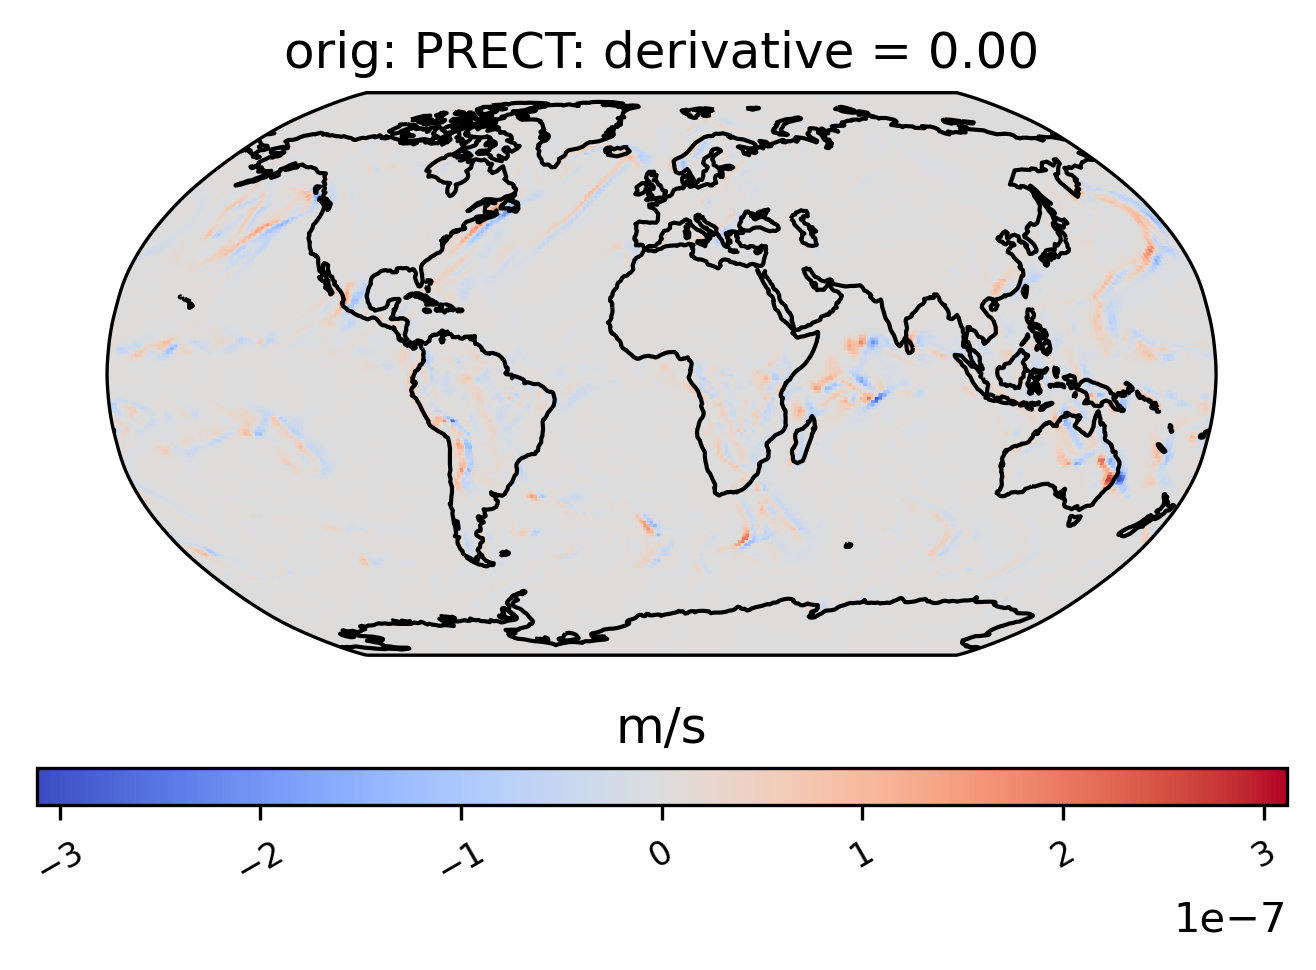

In [84]:
ldcpy.plot(
    col_prect,
    "PRECT",
    sets=["orig"],
    calc="derivative",
    plot_type="spatial",
    start=0,
    end=1,
    weighted=False,
    axes_symmetric=True,
)
# Uncomment to save this image to the filesystem
# import matplotlib.pyplot as plt
# plt.savefig(f"MYFIGURE.png", bbox_inches='tight')

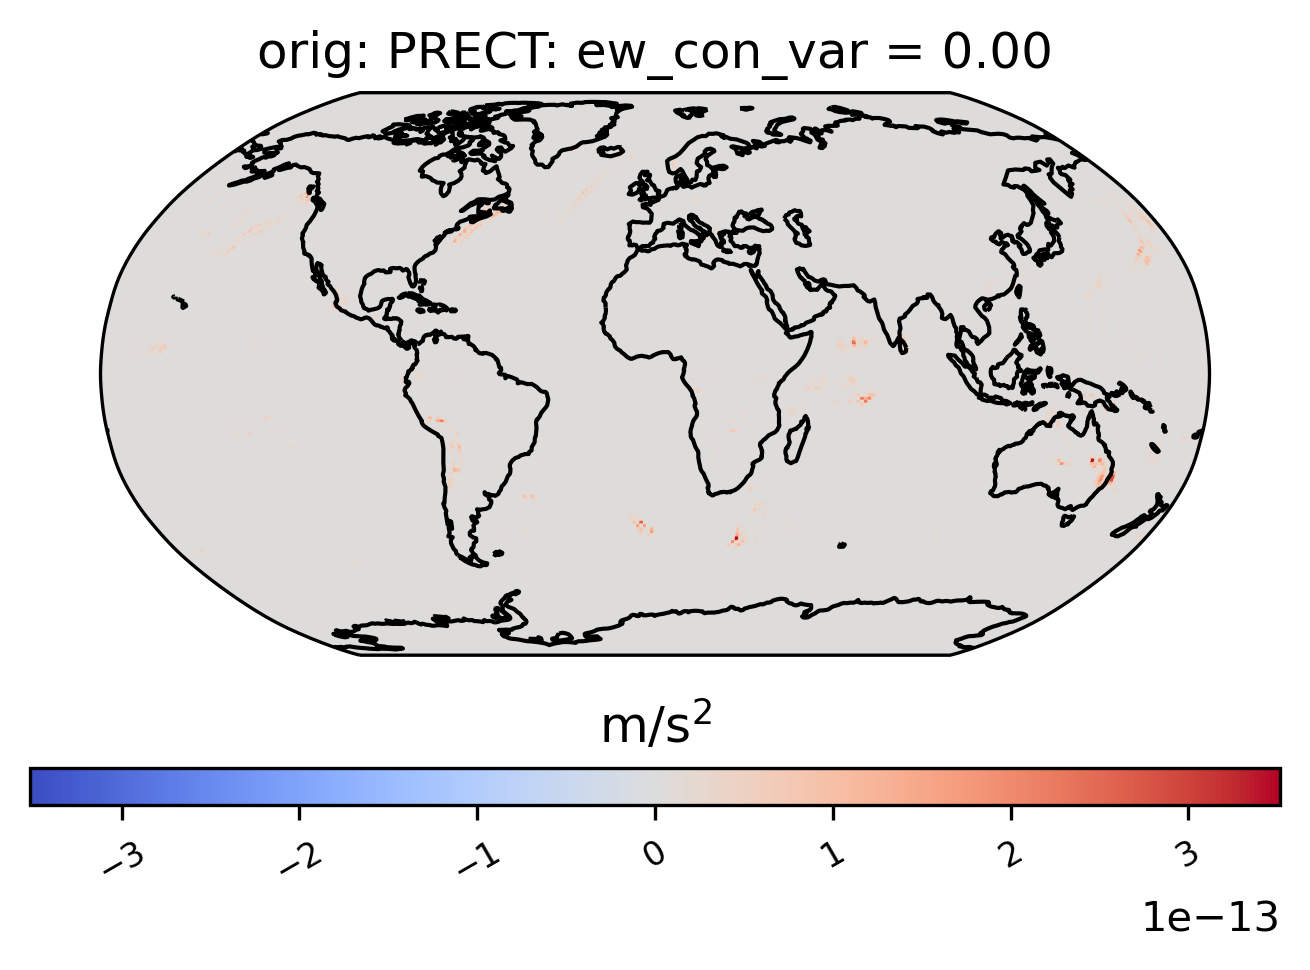

In [85]:
ldcpy.plot(
    col_prect,
    "PRECT",
    sets=["orig"],
    calc="ew_con_var",
    plot_type="spatial",
    start=0,
    end=1,
    weighted=False,
    axes_symmetric=True,
)
# Uncomment to save this image to the filesystem
# import matplotlib.pyplot as plt
# plt.savefig(f"MYFIGURE.png", bbox_inches='tight')

We can also plot quantities other than the mean, such as the standard deviation at
each grid point over time. We can also change the color scheme (for a full list
of quantitiess and color schemes, see the
[documentation](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot)).
Here is an example of a plot of the same dataset from *col_ts* as above but
using a different color scheme and the standard deviation calculation. Notice that we
do not specify the 'plot_type' this time, because it defaults to 'spatial':


In [ ]:
# plot of the standard deviation of TS values in the col_ds "orig" dataset
ldcpy.plot(col_ts, "TS", sets=["orig"], calc="std", color="cmo.thermal")

### Spatial Subsetting <a name="spatial_subsetting"></a>


Plotting a derived quantity of a subset of the data (e.g., not all of the time slices in
the dataset) is possible using the subset keyword. In the plot below, we just
look at "DJF" data (Dec., Jan., Feb.). Other options for subset are available
[here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).


In [ ]:
# plot of mean winter TS values in the col_ts "orig" dataset
ldcpy.plot(col_ts, "TS", sets=["orig"], calc="mean", subset="DJF")

It is also possible to plot calculations for a subset of the time slices by
specifying the start and end indices of the time we are interested in. This
command creates a spatial plot of the mean TS values in "orig" for the first
five days of data:


In [ ]:
# plot of the first 5 TS values in the ds orig dataset
ldcpy.plot(col_ts, "TS", sets=["orig"], calc="mean", start=0, end=5)

Finally, for a 3D dataset, we can specify which vertical level to view using the
"lev" keyword. Note that "lev" is a dimension in our dataset *col_t* (see
printed output for *col_t* above), and in this case lev=30, meaning that lev
ranges from 0 and 29, where 0 is at the surface (by default, lev=0):


In [ ]:
# plot of T values at lev=29 in the col_t "orig" dataset
ldcpy.plot(col_t, "T", sets=["orig"], calc="variance", lev=29)

### Spatial Comparisons and Diff Plots


If we want a side-by-side comparison of two datasets, we need to specify an
additional dataset name in the sets argument. The plot below shows the mean TS
value over time at each point in the 'orig' (original), 'zfpA1.0' (compressed
with zfp, absolute error tolerance 1.0) and 'zfpA1e-1' (compressed with zfp,
absolute error tolerance 0.1) datasets in collection *col_ts* .  The "vert_plot" argument inidcates that the arrangent of the subplots should be vertical.


In [ ]:
# comparison between mean TS values in col_ts for "orig" and "zfpA1.0" datasets
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig", "zfpA1.0", "zfpA1e-1"],
    calc="mean",
    vert_plot=True,
)

To the eye, these plots look identical. This is because the effects of
compression are small compared to the magnitude of the data. We can view the
compression artifacts more clearly by plotting the difference between two plots.
This can be done by setting the calc_type to 'diff':


In [ ]:
# diff between mean TS values in col_ds "orig" and "zfpA1.0" datasets
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig", "zfpA1.0", "zfpA1e-1"],
    calc="mean",
    calc_type="diff",
)

We are not limited to comparing side-by-side plots of the original and
compressed data. It is also possible to compare two different compressed
datasets side-by-side as well, by using a different dataset name for the first
element in sets:


In [ ]:
# comparison between variance of TS values in col_ts for "zfpA1e-1" and "zfpA1.0 datasets"
ldcpy.plot(col_ts, "TS", sets=["zfpA1e-1", "zfpA1.0"], calc="variance")

In [ ]:
# diff between mean TS values in col_ts for "zfpA1e-1" and "zfpA1.0" datasets
ldcpy.plot(
    col_ts,
    "TS",
    sets=["zfpA1e-1", "zfpA1.0"],
    calc="mean",
    calc_type="diff",
)

Sometimes comparison plots can look strikingly different, indicating a potential
problem with the compression. This plot shows the probability of negative
rainfall (PRECT). We would expect this quantity to be zero everywhere on the globe
(because negative rainfall does not make sense!), but the compressed output
shows regions where the probability is significantly higher than zero:


In [ ]:
ldcpy.plot(
    col_prect,
    "PRECT",
    sets=["orig", "zfpA1e-11"],
    calc="prob_negative",
    color="binary",
)

In [ ]:
my_data = col_prect["PRECT"].sel(collection="orig")
ds_calcs_across_time = ldcpy.Datasetcalcs(my_data, ["time"])
prob_neg = ds_calcs_across_time.get_calc("prob_negative")

# trigger computation
prob_neg.load()

### Unusual Values (inf, -inf, NaN)


Some derived quantities result in values that are +/- infinity, or NaN (likely resulting
from operations like 0/0 or inf/inf). NaN values are plotted in neon green,
infinity is plotted in white, and negative infinity is plotted in black
(regardless of color scheme). If infinite values are present in the plot data,
arrows on either side of the colorbar are shown to indicate the color for +/-
infinity. This plot shows the log of the ratio of the odds of positive rainfall
over time in the compressed and original output, log(odds_positive
compressed/odds_positive original). Here we are suppressing all of the divide by
zero warnings for aesthetic reasons.

The following plot showcases some interesting plot features. We can see sections
of the map that take NaN values, and other sections that are black because
taking the log transform has resulted in many points with the value -inf:


In [ ]:
# plot of the ratio of odds positive PRECT values in col_prect zfpA1.0 dataset / col_prect orig dataset (log transform)
ldcpy.plot(
    col_prect,
    "PRECT",
    sets=["orig", "zfpA1e-11"],
    calc="odds_positive",
    calc_type="ratio",
    transform="log",
    axes_symmetric=True,
    vert_plot=True,
)

If all values are NaN, then the colorbar is not shown. Instead, a legend is
shown indicating the green(!) color of NaN values, and the whole plot is colored
gray. (If all values are infinite, then the plot is displayed normally with all
values either black or white). Because the example dataset only contains 60 days
of data, the deseasonalized lag-1 values and their variances are all 0, and so
calculating the correlation of the lag-1 values will involve computing 0/0 =
NaN:


In [ ]:
# plot of lag-1 correlation of PRECT values in col_prect orig dataset
ldcpy.plot(col_prect, "PRECT", sets=["orig", "zfpA1e-7", "zfpA1e-7"], calc="lag1")

### Other Spatial Plots


Sometimes, we may want to compute a quantity on the difference between two
datasets. For instance, the zscore calculation calculates the zscore at each point
under the null hypothesis that the true mean is zero, so using the
"calc_of_diff" calc_type calculates the zscore of the diff between two
datasets (to find the values that are significantly different between the two
datasets). The zscore calculation in particular gives additional information about
the percentage of significant gridpoints in the plot title:


In [ ]:
# plot of z-score under null hypothesis that "orig" value= "zfpA1.0" value
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig", "zfpA1.0", "zfpA1e-1"],
    calc="zscore",
    calc_type="calc_of_diff",
    vert_plot=True,
)

## Time-Series Plots


We may want to aggregate the data spatially and look for trends over time.
Therefore, we can also create a time-series plot of the calculations by changing the
plot_type to "time_series". For time-series plots, the quantity values are on the
y-axis and the x-axis represents time. We are also able to group the data by
time, as shown below.


### Basic Time-Series Plot

In the example below, we look at the 'orig' TS data in collection *col_ts* , and
display the spatial mean at each day of the year (our data consists of 100
days).


In [ ]:
# Time-series plot of TS mean in ds orig dataset
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig"],
    calc="mean",
    plot_type="time_series",
    vert_plot=True,
    legend_loc="best",
)

### Using the group_by keyword


To group the data by time, use the "group_by" keyword. This plot shows the mean
standard deviation over all latitude and longitude points for each month. Note
that this plot is not too interesting for our sample data, which has only 100
days of data.


In [ ]:
# Time-series plot of TS standard deviation in col_ds "orig" dataset, grouped by month
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig"],
    calc="std",
    plot_type="time_series",
    group_by="time.month",
    vert_plot=True,
)

One could also group by days of the year, as below. Again, because we have less
than a year of data, this plot looks the same as the previous version. However,
this approach would be useful with data containing multiple years.


In [ ]:
# Time-series plot of TS mean in col_ts "orig" dataset, grouped by day of year
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig", "zfpA1.0"],
    calc="mean",
    calc_type="calc_of_diff",
    plot_type="time_series",
    group_by="time.dayofyear",
)

We can also overlay multiple sets of time-series data on the same plot. For
instance, we can plot the mean of two datasets over time. Note that the blue and
orange lines overlap almost perfectly:


In [ ]:
# Time-series plot of TS mean in col_ts 'orig' dataset
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig", "zfpA1.0"],
    calc="mean",
    plot_type="time_series",
)

If we change the calc_type to "diff", "ratio" or "calc_of_diff", the first
element in sets is compared against subsequent elements in the sets list. For
example, we can compare the difference in the mean of two compressed datasets to
the original dataset like so:


In [ ]:
# Time-series plot of TS mean differences (with 'orig') in col_ts orig dataset
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig", "zfpA1.0", "zfpA1e-1"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

### Histograms


We can also create a histogram of the data by changing the plot_type to
'histogram'. Note that these histograms are currently generated from time-series
quantity values (a histogram of spatial values is not currently available).

The histogram below shows the mean values of TS in the 'orig' and 'zfpA1.0'
datasets in our collection *col_ts*. Recall that this dataset contains 100
timeslices.


In [ ]:
# Histogram of mean TS values in the col_ts (for'orig' and 'zfpA1.0') dataset

ldcpy.plot(col_ts, "TS", sets=["orig", "zfpA1.0"], calc="mean", plot_type="histogram")

### Other Time-Series Plots


We can create a periodogram based on a dataset as well, by specifying a
plot_type of "periodogram".


In [ ]:
ldcpy.plot(col_ts, "TS", sets=["orig"], calc="mean", plot_type="periodogram")

In [ ]:
ldcpy.plot(col_ts, "TS", sets=["orig"], calc="mean", plot_type="periodogram")

### Subsetting


Subsetting is also possible on time-series data. The following plot makes use of
the subset argument, which is used to plot derived quantities on only a portion of the
data. A full list of available subsets is available
[here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot). The
following plot uses the 'first5' subset, which only shows the quantity values for
the first five time slices (in this case, days) of data:


In [ ]:
# Time-series plot of first five TS standard deviations in col_ts "orig" dataset
ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig"],
    calc="std",
    plot_type="time_series",
    subset="first5",
)

Additionally, we can specify "lat" and "lon" keywords for time-series plots that
give us a subset of the data at a single point, rather than averaging over all
latitudes and longitudes. The nearest latitude and longitude point to the one
specified is plotted (and the actual coordinates of the point can be found in
the plot title). This plot, for example, shows the difference in mean rainfall
between the compressed and original data at the location (44.76, -123.75):


In [ ]:
# Time series plot of PRECT mean data for col_prect "zfpA1e-7" dataset at the location (44.76, -123.75)

ldcpy.plot(
    col_prect,
    "PRECT",
    sets=["zfpA1e-7"],
    calc="mean",
    plot_type="time_series",
    lat=44.76,
    lon=-123.75,
)

In [ ]:
# Time series plot of PRECT mean data for col_prect "zfpA1e-7" dataset at the location (44.76, -123.75)

ldcpy.plot(col_prect, "PRECT", sets=["zfpA1e-7"], calc="mean", plot_type="time_series")

It is also possible to plot quantities for a subset of the data, by specifying the
start and end indices of the data we are interested in. This command creates a
time-series plot of the mean TS values for the first 45 days of data:


In [ ]:
# Time series plot of first 45 TS mean data points for col_ts "orig" dataset

ldcpy.plot(
    col_ts,
    "TS",
    sets=["orig"],
    calc="mean",
    start=0,
    end=44,
    plot_type="time_series",
)